# Recherche d'un seuil pour le score sparse 
### Objectif

On cherche à déterminer un seuil optimal pour lequel on décide d'afficher la réponse ou pas. <br>
*exemple: si seuil < 0.3, ne pas afficher la réponse*
- D'abord on fait une *analyse statistique* rapide pour voir quelle est la distribution du score pour l'erreur et pour le succes du sparse
- On tente ensuite une approche Machine Learning pour *classifier* 0: erreur (= on affiche pas la réponse) et 1: success (=on affiche la réponse)
- On ouvre sur des potentielles pistes un peu plus 'probabilistes' et on propose d'aller plus loin dans la recherche d'une solution au problème
<br>

*Attention*, ici on utilise le dataset 'analysis_resultst.csv' (Robin), on s'intéresse exclusivement au **score sparse** et on se restraint au cas **k=5**. <br>
D'abord le cas **with lemma**.

In [44]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [46]:
data = pd.read_csv("analysis_results.csv")
len(data)

36771

In [47]:
data = data[data['position_sparse_lemma']==5.0]
len(data) #626 résultats pour k = 5 (with lemma)

626

In [48]:
suc = data[data['fiche_ok'] == True] 
suc_nan = suc[pd.isnull(suc['score_sparse_lemma'])]['score_sparse_lemma'] 
print(len(suc)) #111 success pour k = 5 et retriever sparse (with lemma)
suc['label'] = ['succes' for x in range(len(suc))]

111


In [49]:
err = data[data['fiche_ok'] == False] #512 erreurs pour sparse et k = 5
err = err[~pd.isnull(err['score_sparse_lemma'])] 
print(len(err))
err['label'] = ['error' for x in range(len(err))]

512


In [50]:
data2 = pd.concat([suc,err])

## Analyse statistique 

**Boxplot pour erreurs et succes du sparse**

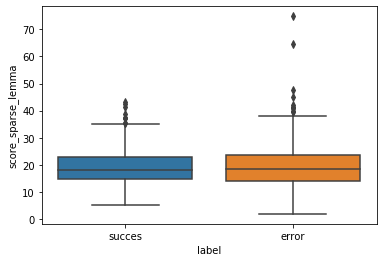

In [51]:
ax = sns.boxplot(x="label", y="score_sparse_lemma", data=data2)

Text(0.5, 1.0, 'Distribution of errors')

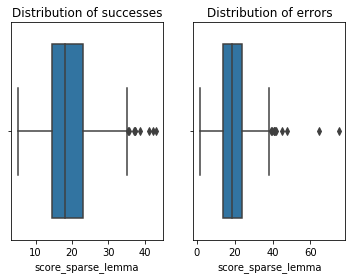

In [52]:
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x=suc['score_sparse_lemma']) #distribution success
plt.title("Distribution of successes")
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x=err['score_sparse_lemma']) #distribution erreur
plt.title("Distribution of errors")


**Statistiques déscriptives**

In [53]:
from statistics import median
median_error = median(err['score_sparse_lemma'])
median_success = median(suc['score_sparse_lemma'])
stata = data2.groupby(['label']).describe()['score_sparse_lemma']
stata['median'] = [median(err['score_sparse_lemma']),median(suc['score_sparse_lemma'])]
stata

,count,mean,std,min,25%,50%,75%,max,median
label,,,,,,,,,
error,512.0,19.614372,8.302991,1.884695,14.099058,18.620067,23.755569,74.822464,18.620067
succes,111.0,19.614263,7.799816,5.038723,14.587464,18.117577,22.929906,43.085250,18.117577


**Correlation**

In [54]:
#encoding labels
from sklearn.preprocessing import LabelEncoder
data2['label_encoded'] = LabelEncoder().fit_transform(data2['label'])
#0: error, #1:success

In [55]:
#correlation
corr = data2.corr()

**Density**

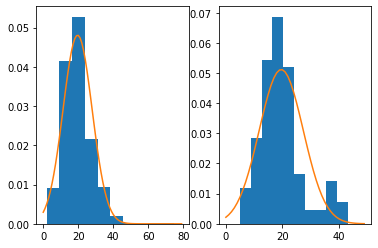

In [57]:
import scipy.stats as stats
plt.subplot(1, 2, 1)
x =[i for i in range(len(err['score_sparse_lemma']))]
plt.hist(err['score_sparse_lemma'],density=True)
y = [i for i in range(0,80)]
plt.plot(y, stats.norm.pdf(y, 19.614372, 8.302991))
plt.subplot(1, 2, 2)
x =[i for i in range(len(suc['score_sparse_lemma']))]
plt.hist(suc['score_sparse_lemma'],density=True)
y = [i for i in range(0,50)]
plt.plot(y, stats.norm.pdf(y,19.614263, 7.799816))

## Approche ML: classification ERROR /SUCCESS

*On souhaiterait obtenir un classifieur qui, en fonction du score, puisse prédire 0: 'le retiever sparse va faire une erreur', 1: 'le retriever sparse va trouver la bonne réponse'. Ceci nous permetterait de décider si afficher la réponse (1) ou pas (0).* <br>
On fait une regression logistique.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [59]:
X_clf = data2['score_sparse_lemma']
Y_clf = data2['label_encoded']
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf , Y_clf, test_size=0.2, random_state=42)
X_train_clf= np.array(X_train_clf).reshape((-1,1))
X_test_clf= np.array(X_test_clf).reshape((-1,1))
y_train_clf= np.array(y_train_clf).reshape((-1,1))
y_test_clf= np.array(y_test_clf).reshape((-1,1))

In [60]:
clf = LogisticRegression()
clf.fit(X_train_clf, y_train_clf)
y_pred_clf = clf.predict(X_test_clf)
print(y_pred_clf) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Metrics:

In [61]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
print(metrics.classification_report(y_test_clf, y_pred_clf))
print("roc_auc_score: ", roc_auc_score(y_test_clf, y_pred_clf))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       100
           1       0.00      0.00      0.00        25

    accuracy                           0.80       125
   macro avg       0.40      0.50      0.44       125
weighted avg       0.64      0.80      0.71       125

roc_auc_score:  0.5


Modèle pas performant, le problème pourrait venir du fait que la classe *success* est sous-représentée. <br>
**Dans la suite on balance les classes**

In [62]:
#on balance les classes:
from sklearn.utils import class_weight
X_clf2 = data2['score_sparse_lemma']
Y_clf2 = data2['label_encoded']
X_train_clf2, X_test_clf2, y_train_clf2, y_test_clf2 = train_test_split(X_clf2 , Y_clf2, test_size=0.2, random_state=42)
X_train_clf2= np.array(X_train_clf2).reshape((-1,1))
X_test_clf2= np.array(X_test_clf2).reshape((-1,1))
y_train_clf2= np.array(y_train_clf2).reshape((-1,1))
y_test_clf2= np.array(y_test_clf2).reshape((-1,1))

In [63]:
clf2 = LogisticRegression(class_weight='balanced')
clf2.fit(X_train_clf2, y_train_clf2) 
y_pred_clf2 = clf2.predict(X_test_clf2)
print(y_pred_clf2)
print(metrics.classification_report(y_test_clf2, y_pred_clf2))
print("roc_auc_score: ", roc_auc_score(y_test_clf2, y_pred_clf2))

[1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 1 1 0 0 1 1 0 1]
              precision    recall  f1-score   support

           0       0.77      0.55      0.64       100
           1       0.17      0.36      0.23        25

    accuracy                           0.51       125
   macro avg       0.47      0.46      0.44       125
weighted avg       0.65      0.51      0.56       125

roc_auc_score:  0.455


In [64]:
#on 'force' un certain poids
from sklearn.utils import class_weight
X_clf3 = data2['score_sparse_lemma']
Y_clf3 = data2['label_encoded']
X_train_clf3, X_test_clf3, y_train_clf3, y_test_clf3 = train_test_split(X_clf3 , Y_clf3, test_size=0.2, random_state=42)
X_train_clf3= np.array(X_train_clf3).reshape((-1,1))
X_test_clf3= np.array(X_test_clf3).reshape((-1,1))
y_train_clf3= np.array(y_train_clf3).reshape((-1,1))
y_test_clf3= np.array(y_test_clf3).reshape((-1,1))

In [65]:
class_weights = {0:.17,1:.83}
clf3 = LogisticRegression(class_weight=class_weights)
clf3.fit(X_train_clf3, y_train_clf3) 
y_pred_clf3 = clf3.predict(X_test_clf3)
print(y_pred_clf3)
print(metrics.classification_report(y_test_clf3, y_pred_clf3))
print("roc_auc_score: ", roc_auc_score(y_test_clf3, y_pred_clf3))

[1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0
 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1
 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0
 1 1 1 0 0 1 1 1 0 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.83      0.40      0.54       100
           1       0.22      0.68      0.33        25

    accuracy                           0.46       125
   macro avg       0.53      0.54      0.44       125
weighted avg       0.71      0.46      0.50       125

roc_auc_score:  0.54


## Approche probabiliste/autres pistes possibles


**Idée 1**: traiter les questions comme des variables suivant une loi de Bernouilli(p), c'est à dire:
- avec proba p, j'aurai 0 (= erreur)
- avec proba 1-p, j'aurai 1 (= succes)

et faire un test/des test statistiques avec différentes valeurs de $\ p = p_{0}$ pour déterminer le seuil optimal $\ p_{0}$

Avantage:

- solide du point de vue théorique

Gros problème:

- est-ce que la proba calculée par le retriever est une 'vraie' proba au sens mathématique du terme? Est ce que le score (ramené sur [0,1]) peut etre considéré / traité comme une proba? 

**Idée 2**: puisque errors et successes semblent (un peu près) suivre un modèle gaussien, tenter un GMM (gaussian mixture model) à traiter avec l'algorithme EM.

# Conclusions et suite

- une approche de classification ne semble par etre très performante pour traiter le problème
- problème principal: les erreurs et les success semblent suivre une distribution quasiment égale (même moyenne, quasiement même maximum et minimum etc.). Il semblerait donc que le score pour chaque question soit 'indépendant' (40% peut etre un bon score pour une question mais pas pour une autre).

A faire:
- plus creuser les stats (ici on s'est restraint à k = 5, voir si pour k!= 5 le score se comporte de manière différente)
- (avec Pavel): faire un peu de recherche pour mieux comprendre pourquoi on a cette distribution et éventuellement voir si le problème a déjà été resolu
- peut-être passer à la recherche d'un score plus performant pour le dense ? (peut etre plus facile à traiter). Le sparse donne cependant des meilleurs résultats donc par forçement utile.


